In [1]:
# Based on http://nlp.cs.washington.edu/zeroshot/evaluate.py
import pandas as pd
import os
import codecs
import re
import string
import sys
import numpy as np

PUNCTUATION = set(string.punctuation)

import re

def remove_latin(text):
    return re.sub(r'[^\x00-\x7f]',r'', text)

def unk_zero_re_eval(test_file, answer_file):
    q_aprf = unk_read_results(test_file, answer_file)
    return pretify(q_aprf)

def unk_read_results(test_set, answer_file):
    with codecs.open(test_set, "r", "utf-8") as fin:
        data = [line.strip().split("\t") for line in fin]
    metadata = [x[:4] for x in data]
    gold = [set(x[4:]) for x in data]

    with codecs.open(answer_file, "r", "utf-8") as fin:
        answers = [line.strip() for line in fin]

    new_answers = []
    for answer in answers[1:]:
        if answer != "no_answer":
            new_answers.append(answer)
        else:
            new_answers.append("")

    telemetry = []
    for m, g, a in zip(metadata, gold, new_answers):
        stats = score(g, a)
        telemetry.append([m[0], m[1], str(len(g) > 0), stats])
    return aprf(telemetry)

def parse_no_answers(results):
    p_answer = [
        a for i, a in sorted([(int(i), a) for i, a in results[0]["scores"].items()])
    ]
    p_no_answer = [
        a for i, a in sorted([(int(i), a) for i, a in results[0]["na"].items()])
    ]

    import numpy as np

    return [answer > no_answer for answer, no_answer in zip(p_answer, p_no_answer)]


def gb(collection, keyfunc):
    return [(k, list(g)) for k, g in groupby(sorted(collection, key=keyfunc), keyfunc)]


def aprf(g):
    tp, tn, sys_pos, real_pos = sum(map(lambda x: x[-1], g))
    total = len(g)
    # a = float(tp + tn) / total
    # nr = tn / float(total - real_pos)
    # npr = tn / float(total - sys_pos)
    if tp == 0:
        p = r = f = 0.0
    else:
        p = tp / float(sys_pos)
        r = tp / float(real_pos)
        f = 2 * p * r / (p + r)
    # return np.array((a, p, r, f, npr, nr))
    return np.array((p, r, f))


def score(gold, answer):
    if len(gold) > 0:
        gold = set.union(*[simplify(g) for g in gold])
    answer = simplify(answer)
    result = np.zeros(4)
    if answer == gold:
        if len(gold) > 0:
            result[0] += 1
        else:
            result[1] += 1
    if len(answer) > 0:
        result[2] += 1
    if len(gold) > 0:
        result[3] += 1
    return result


def simplify(answer):
    return set(
        "".join(c for c in t if c not in PUNCTUATION)
        for t in answer.strip().lower().split()
    ) - {"the", "a", "an", "and", ""}


def pretify(results):
    return " \t ".join(
        [
            ": ".join((k, v))
            for k, v in zip(
                ["Precision", "Recall", "F1"],
                map(lambda r: "{0:.2f}%".format(r * 100), results),
            )
        ]
    )

In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

device = "cuda"
model_id = "gpt2-large"
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

In [18]:
import torch
def compute_perplexity_for_questions(main_path, file):
    ppls = []
    df = pd.read_csv(os.path.join(main_path, file), sep=',')
    questions = df["question_predictions"].tolist()
    for question in questions:
        encodings = tokenizer(question, return_tensors="pt")
        input_ids = encodings.input_ids.to(device)
        b_sz, length = input_ids.size()
        target_ids = input_ids.clone()
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs[0]
            ppl = torch.exp(neg_log_likelihood)
        ppls.append(ppl)
    ppl = torch.stack(ppls).mean()
    return ppl

def gold_compute_perplexity_for_questions(main_path, file):
    ppls = []
    df = pd.read_csv(os.path.join(main_path, file), sep=',')
    inputs = df["input_str"].tolist()
    for inp in inputs:
        question = inp.split("context:")[0].replace("question:", "").strip()
        encodings = tokenizer(question, return_tensors="pt")
        input_ids = encodings.input_ids.to(device)
        b_sz, length = input_ids.size()
        target_ids = input_ids.clone()
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs[0]
            ppl = torch.exp(neg_log_likelihood)
        ppls.append(ppl)
    ppl = torch.stack(ppls).mean()
    return ppl

In [2]:
def preprocess_the_prediction_files(main_path, list_of_files):
    for file in list_of_files:
        df = pd.read_csv(os.path.join(main_path, file), sep=',')
        df["predictions_str"].to_csv(os.path.join("/tmp/", file), sep='\t', header=True, index=False)

def unk_eval_the_prediction_files(list_of_files, gold_file):
    scores = {}
    scores_list = []
    precision_list = []
    recall_list = []
    for file in list_of_files:
        score = unk_zero_re_eval(gold_file, os.path.join("/tmp/", file))
        arr = score.split()
        f1_score = float(arr[-1][0:-1])
        precision = float(arr[1][0:-1])
        recall = float(arr[3][0:-1])
        scores[f1_score] = file
        scores_list.append(f1_score)
        precision_list.append(precision)
        recall_list.append(recall)

    f1s = np.array(scores_list)
    precisions = np.array(precision_list)
    recalls = np.array(recall_list)
    max_f1 = max(scores.keys())
    return scores[max_f1],  max_f1, f1s, scores, precisions, recalls

In [4]:
results = {}
for fold_i in range(1, 11, 1):
    results[fold_i] = {'mml-pgg-off-sim': {},
                       'mml-pgg-on-sim': {},
                       'mml-mml-off-sim': {},
                       'mml-mml-on-sim': {}}

In [7]:
# Evaluating the dev predictions on the RE-QA dataset on fold 1.
folders = ["mml-pgg-off-sim", "mml-pgg-on-sim", "mml-mml-off-sim", "mml-mml-on-sim"]

for fold_i in range(1, 11, 1):
    for folder in folders:
        fold_gold_file = "./zero-shot-extraction/relation_splits/dev.{}".format(fold_i-1)
        fold_path = "~/fold_{}/{}/".format(fold_i, folder)
        if fold_i == 1:
            fold_files = ["{}.fold.{}.dev.predictions.step.{}.csv".format(folder, fold_i, 100 * i) for i in range(1, 101, 1)]
        elif 2 <= fold_i <= 4:
            if folder == "mml-pgg-off-sim":
                fold_files = ["{}.fold.{}.dev.predictions.step.{}.csv".format(folder, fold_i, 100 * i) for i in range(1, 101, 1)]
            else:
                fold_files = ["{}.dev.predictions.fold.{}.step.{}.csv".format(folder, fold_i, 100 * i) for i in range(1, 101, 1)]
        else:
            if folder == "mml-pgg-off-sim":
                fold_files = ["{}.fold.{}.dev.predictions.step.{}.csv".format(folder, fold_i, 100 * i) for i in range(1, 201, 1)]
            else:
                fold_files = ["{}.dev.predictions.fold.{}.step.{}.csv".format(folder, fold_i, 100 * i) for i in range(1, 201, 1)]
    
        preprocess_the_prediction_files(fold_path, fold_files)
        max_file,  max_f1, f1s, scores, precisions, recalls = unk_eval_the_prediction_files(fold_files, fold_gold_file)
        print(folder, fold_i, max_file, max_f1)
        print("\n")
        results[fold_i][folder] = max_file
    print("NEXT")

mml-pgg-off-sim 1 mml-pgg-off-sim.fold.1.dev.predictions.step.500.csv 49.45


mml-pgg-on-sim 1 mml-pgg-on-sim.fold.1.dev.predictions.step.300.csv 53.57


mml-mml-off-sim 1 mml-mml-off-sim.fold.1.dev.predictions.step.500.csv 48.79


mml-mml-on-sim 1 mml-mml-on-sim.fold.1.dev.predictions.step.8900.csv 50.56


NEXT
mml-pgg-off-sim 2 mml-pgg-off-sim.fold.2.dev.predictions.step.9300.csv 64.03


mml-pgg-on-sim 2 mml-pgg-on-sim.dev.predictions.fold.2.step.9200.csv 62.0


mml-mml-off-sim 2 mml-mml-off-sim.dev.predictions.fold.2.step.9300.csv 64.77


mml-mml-on-sim 2 mml-mml-on-sim.dev.predictions.fold.2.step.9400.csv 62.34


NEXT
mml-pgg-off-sim 3 mml-pgg-off-sim.fold.3.dev.predictions.step.5300.csv 58.42


mml-pgg-on-sim 3 mml-pgg-on-sim.dev.predictions.fold.3.step.300.csv 57.72


mml-mml-off-sim 3 mml-mml-off-sim.dev.predictions.fold.3.step.3800.csv 59.03


mml-mml-on-sim 3 mml-mml-on-sim.dev.predictions.fold.3.step.2000.csv 61.22


NEXT
mml-pgg-off-sim 4 mml-pgg-off-sim.fold.4.dev.predictio

In [9]:
# Evaluating the dev predictions on the RE-QA dataset on fold 1.
folders = ["mml-pgg-on-sim", "mml-mml-off-sim", "mml-mml-on-sim", "mml-pgg-off-sim"]

#results[1]["mml-pgg-off-sim"] = "mml-pgg-off-sim.fold.1.test.predictions.step.500.csv"
#results[2]["mml-pgg-off-sim"] = "mml-pgg-off-sim.fold.2.test.predictions.step.22700.csv"
#results[3]["mml-pgg-off-sim"] = "mml-pgg-off-sim.fold.3.test.predictions.step.12400.csv"
#results[4]["mml-pgg-off-sim"] = "mml-pgg-off-sim.fold.4.test.predictions.step.1100.csv"
#results[5]["mml-pgg-off-sim"] = "mml-pgg-off-sim.fold.5.test.predictions.step.6400.csv"
#results[6]["mml-pgg-off-sim"] = "mml-pgg-off-sim.fold.6.test.predictions.step.700.csv"
#results[7]["mml-pgg-off-sim"] = "mml-pgg-off-sim.fold.7.test.predictions.step.14900.csv"
results[9]["mml-pgg-off-sim"] = "mml_pgg_off_sim.test.predictions.step.2900.csv"
#results[8]["mml-pgg-off-sim"] = "mml-pgg-off-sim.fold.8.test.predictions.step.8600.csv"
#results[10]["mml-pgg-off-sim"] = "mml_pgg_off_sim.test.predictions.step.29000.csv"

for folder in folders:
    avg_f1 = {"mml-mml-off-sim": 0, "mml-mml-on-sim": 0, "mml-pgg-on-sim": 0, "mml-pgg-off-sim": 0}
    avg_p = {"mml-mml-off-sim": 0, "mml-mml-on-sim": 0, "mml-pgg-on-sim": 0, "mml-pgg-off-sim": 0}
    avg_r = {"mml-mml-off-sim": 0, "mml-mml-on-sim": 0, "mml-pgg-on-sim": 0, "mml-pgg-off-sim": 0}
    for fold_i in range(1, 11, 1):
        fold_gold_file = "./zero-shot-extraction/relation_splits/test.{}".format(fold_i-1)
        fold_path = "~/fold_{}/{}".format(fold_i, folder)
        fold_files = [results[fold_i][folder].replace("dev", "test")]
        preprocess_the_prediction_files(fold_path, fold_files)
        max_file,  max_f1, f1s, scores, precisions, recalls = unk_eval_the_prediction_files(fold_files, fold_gold_file)
        print(folder, fold_i, max_file, max_f1)
        avg_f1[folder] += max_f1
        avg_p[folder] += precisions[0]
        avg_r[folder] += recalls[0]
        print("\n")

    print(folder, "f1", avg_f1[folder] / 10.0)
    print(folder, "p", avg_p[folder] / 10.0)
    print(folder, "r", avg_r[folder] / 10.0)
    print("NEXT")

mml-pgg-on-sim 1 mml-pgg-on-sim.fold.1.test.predictions.step.300.csv 59.19


mml-pgg-on-sim 2 mml-pgg-on-sim.test.predictions.fold.2.step.9200.csv 44.62


mml-pgg-on-sim 3 mml-pgg-on-sim.test.predictions.fold.3.step.300.csv 55.39


mml-pgg-on-sim 4 mml-pgg-on-sim.test.predictions.fold.4.step.500.csv 61.62


mml-pgg-on-sim 5 mml-pgg-on-sim.test.predictions.fold.5.step.12600.csv 53.77


mml-pgg-on-sim 6 mml-pgg-on-sim.test.predictions.fold.6.step.300.csv 55.71


mml-pgg-on-sim 7 mml-pgg-on-sim.test.predictions.fold.7.step.9800.csv 59.5


mml-pgg-on-sim 8 mml-pgg-on-sim.test.predictions.fold.8.step.17000.csv 56.03


mml-pgg-on-sim 9 mml-pgg-on-sim.test.predictions.fold.9.step.2300.csv 51.6


mml-pgg-on-sim 10 mml-pgg-on-sim.test.predictions.fold.10.step.4300.csv 47.59


mml-pgg-on-sim f1 54.501999999999995
mml-pgg-on-sim p 57.011
mml-pgg-on-sim r 52.552
NEXT
mml-mml-off-sim 1 mml-mml-off-sim.fold.1.test.predictions.step.500.csv 63.37


mml-mml-off-sim 2 mml-mml-off-sim.test.predictions.fo

In [38]:
'''
mml-pgg-on-sim.fold.1.test.predictions.step.300.csv tensor(1260.9260, device='cuda:0')
mml-pgg-on-sim.test.predictions.fold.2.step.9200.csv tensor(235.0195, device='cuda:0')
mml-pgg-on-sim.test.predictions.fold.3.step.300.csv tensor(1381.7130, device='cuda:0')
mml-pgg-on-sim.test.predictions.fold.4.step.500.csv tensor(387.9579, device='cuda:0')
mml-pgg-on-sim.test.predictions.fold.5.step.12600.csv tensor(132.0265, device='cuda:0')
mml-pgg-on-sim.test.predictions.fold.6.step.300.csv tensor(896.1946, device='cuda:0')
mml-pgg-on-sim.test.predictions.fold.7.step.9800.csv tensor(2560.6672, device='cuda:0')
mml-pgg-on-sim.test.predictions.fold.8.step.17000.csv tensor(132.0265, device='cuda:0')
mml-pgg-on-sim.test.predictions.fold.9.step.2300.csv tensor(5997.6045, device='cuda:0')
mml-pgg-on-sim.test.predictions.fold.10.step.4300.csv tensor(172.6929, device='cuda:0')
'''

"\nmml-pgg-on-sim.fold.1.test.predictions.step.300.csv tensor(1260.9260, device='cuda:0')\nmml-pgg-on-sim.test.predictions.fold.2.step.9200.csv tensor(235.0195, device='cuda:0')\nmml-pgg-on-sim.test.predictions.fold.3.step.300.csv tensor(1381.7130, device='cuda:0')\nmml-pgg-on-sim.test.predictions.fold.4.step.500.csv tensor(387.9579, device='cuda:0')\nmml-pgg-on-sim.test.predictions.fold.5.step.12600.csv tensor(132.0265, device='cuda:0')\nmml-pgg-on-sim.test.predictions.fold.6.step.300.csv tensor(896.1946, device='cuda:0')\nmml-pgg-on-sim.test.predictions.fold.7.step.9800.csv tensor(2560.6672, device='cuda:0')\nmml-pgg-on-sim.test.predictions.fold.8.step.17000.csv tensor(132.0265, device='cuda:0')\nmml-pgg-on-sim.test.predictions.fold.9.step.2300.csv tensor(5997.6045, device='cuda:0')\nmml-pgg-on-sim.test.predictions.fold.10.step.4300.csv tensor(172.6929, device='cuda:0')\n"

In [10]:
folders = ["mml-mml-off-sim"]

for folder in folders:
    avg_pp = {"mml-mml-off-sim": 0, "mml-mml-on-sim": 0, "mml-pgg-on-sim": 0, "mml-pgg-off-sim": 0}
    for fold_i in range(1, 11, 1):
        fold_path = "~/fold_{}/{}".format(fold_i, folder)
        fold_file = results[fold_i][folder].replace("dev", "test")
        pp = compute_perplexity_for_questions(fold_path, fold_file)
        avg_pp[folder] += pp
        print(fold_file, pp)
    print("\n")
    print(folder, "pp", avg_pp[folder] / 10.0)

mml-mml-off-sim.fold.1.test.predictions.step.500.csv tensor(256.7630, device='cuda:0')
mml-mml-off-sim.test.predictions.fold.2.step.9300.csv tensor(113.4473, device='cuda:0')
mml-mml-off-sim.test.predictions.fold.3.step.3800.csv tensor(125.6059, device='cuda:0')
mml-mml-off-sim.test.predictions.fold.4.step.2300.csv tensor(168.9407, device='cuda:0')
mml-mml-off-sim.test.predictions.fold.5.step.3000.csv tensor(226.4696, device='cuda:0')
mml-mml-off-sim.test.predictions.fold.6.step.300.csv tensor(136.6262, device='cuda:0')
mml-mml-off-sim.test.predictions.fold.7.step.13400.csv tensor(181.6257, device='cuda:0')
mml-mml-off-sim.test.predictions.fold.8.step.7900.csv tensor(158.8159, device='cuda:0')
mml-mml-off-sim.test.predictions.fold.9.step.4700.csv tensor(113.4427, device='cuda:0')
mml-mml-off-sim.test.predictions.fold.10.step.1500.csv tensor(29.8569, device='cuda:0')


mml-mml-off-sim pp tensor(151.1594, device='cuda:0')


In [11]:
folders = ["mml-pgg-off-sim"]

for folder in folders:
    avg_pp = {"mml-mml-off-sim": 0, "mml-mml-on-sim": 0, "mml-pgg-on-sim": 0, "mml-pgg-off-sim": 0}
    for fold_i in [2, 3, 10]:
        fold_path = "~/fold_{}/{}".format(fold_i, folder)
        fold_file = results[fold_i][folder].replace("dev", "test")
        pp = compute_perplexity_for_questions(fold_path, fold_file)
        avg_pp[folder] += pp
        print(fold_file, pp)
    print("\n")
    print(folder, "pp", avg_pp[folder] / 10.0)

mml-pgg-off-sim.fold.2.test.predictions.step.9300.csv tensor(125.3252, device='cuda:0')
mml-pgg-off-sim.fold.3.test.predictions.step.5300.csv tensor(134.4366, device='cuda:0')
mml-pgg-off-sim.fold.10.test.predictions.step.8600.csv tensor(162.4130, device='cuda:0')


mml-pgg-off-sim pp tensor(42.2175, device='cuda:0')


In [ ]:
'''
mml-pgg-off-sim.fold.1.test.predictions.step.500.csv tensor(222.5217, device='cuda:0')
mml-pgg-off-sim.fold.4.test.predictions.step.1100.csv tensor(156.0715, device='cuda:0')
mml-pgg-off-sim.fold.5.test.predictions.step.6400.csv tensor(166.6490, device='cuda:0')
mml-pgg-off-sim.fold.6.test.predictions.step.700.csv tensor(124.1455, device='cuda:0')
mml-pgg-off-sim.fold.7.test.predictions.step.14900.csv tensor(154.3446, device='cuda:0')
mml-pgg-off-sim.fold.8.test.predictions.step.8600.csv tensor(119.3474, device='cuda:0')
mml_pgg_off_sim.test.predictions.step.2900.csv tensor(101.8666, device='cuda:0')
mml-pgg-off-sim.fold.2.test.predictions.step.9300.csv tensor(125.3252, device='cuda:0')
mml-pgg-off-sim.fold.3.test.predictions.step.5300.csv tensor(134.4366, device='cuda:0')
mml-pgg-off-sim.fold.10.test.predictions.step.8600.csv tensor(162.4130, device='cuda:0')

mml-mml-on-sim.fold.1.test.predictions.step.8900.csv tensor(5113.3140, device='cuda:0')
mml-mml-on-sim.test.predictions.fold.2.step.9400.csv tensor(1238.2205, device='cuda:0')
mml-mml-on-sim.test.predictions.fold.3.step.2000.csv tensor(407.7806, device='cuda:0')
mml-mml-on-sim.test.predictions.fold.4.step.4200.csv tensor(14371.8291, device='cuda:0')
mml-mml-on-sim.test.predictions.fold.5.step.12800.csv tensor(716.9070, device='cuda:0')
mml-mml-on-sim.test.predictions.fold.6.step.2200.csv tensor(30948.2246, device='cuda:0')
mml-mml-on-sim.test.predictions.fold.7.step.16600.csv tensor(2601.8579, device='cuda:0')
mml-mml-on-sim.test.predictions.fold.8.step.7200.csv tensor(42924.8516, device='cuda:0')
mml-mml-on-sim.test.predictions.fold.9.step.1900.csv tensor(1510.6766, device='cuda:0')
mml-mml-on-sim.test.predictions.fold.10.step.5800.csv tensor(29.8569, device='cuda:0')
'''

In [10]:
folders = ["mml-mml-on-sim"]

for folder in folders:
    avg_pp = {"mml-mml-off-sim": 0, "mml-mml-on-sim": 0, "mml-pgg-on-sim": 0, "mml-pgg-off-sim": 0}
    for fold_i in range(10, 11, 1):
        fold_path = "~/fold_{}/{}".format(fold_i, folder)
        fold_file = results[fold_i][folder].replace("dev", "test")
        pp = compute_perplexity_for_questions(fold_path, fold_file)
        avg_pp[folder] += pp
        print(fold_file, pp)
    print("\n")
    print(folder, "pp", avg_pp[folder] / 10.0)

mml-mml-on-sim.test.predictions.fold.10.step.5800.csv tensor(29.8569, device='cuda:0')


mml-mml-on-sim pp tensor(2.9857, device='cuda:0')


In [7]:
# PP for the base-base predictions.
avg_pp = 0.0
for fold_i in range(1, 11, 1):
    fold_path = "~/"
    fold_file = "base_base_fold.{}.test.predictions.step.csv".format(fold_i)
    pp = compute_perplexity_for_questions(fold_path, fold_file)
    avg_pp += pp
    print(fold_file, pp)

print("\n")
print("pp", avg_pp / 10.0)

base_base_fold.1.test.predictions.step.csv tensor(215.8548, device='cuda:0')
base_base_fold.2.test.predictions.step.csv tensor(181.5120, device='cuda:0')
base_base_fold.3.test.predictions.step.csv tensor(128.0450, device='cuda:0')
base_base_fold.4.test.predictions.step.csv tensor(185.9727, device='cuda:0')
base_base_fold.5.test.predictions.step.csv tensor(196.0677, device='cuda:0')
base_base_fold.6.test.predictions.step.csv tensor(138.5674, device='cuda:0')
base_base_fold.7.test.predictions.step.csv tensor(219.6459, device='cuda:0')
base_base_fold.8.test.predictions.step.csv tensor(206.5881, device='cuda:0')
base_base_fold.9.test.predictions.step.csv tensor(163.6257, device='cuda:0')
base_base_fold.10.test.predictions.step.csv tensor(179.0245, device='cuda:0')


pp tensor(181.4904, device='cuda:0')


In [20]:
# PP for the gold predictions.
avg_pp = 0.0
for fold_i in range(1, 11, 1):
    fold_path = "~/"
    fold_file = "gold_fold.{}.test.predictions.step..csv".format(fold_i)
    pp = gold_compute_perplexity_for_questions(fold_path, fold_file)
    avg_pp += pp
    print(fold_file, pp)

print("\n")
print("pp", avg_pp / 10.0)

gold_fold.1.test.predictions.step..csv tensor(406.0290, device='cuda:0')
gold_fold.2.test.predictions.step..csv tensor(505.0843, device='cuda:0')
gold_fold.3.test.predictions.step..csv tensor(392.8392, device='cuda:0')
gold_fold.4.test.predictions.step..csv tensor(448.9874, device='cuda:0')
gold_fold.5.test.predictions.step..csv tensor(483.6721, device='cuda:0')
gold_fold.6.test.predictions.step..csv tensor(367.5929, device='cuda:0')
gold_fold.7.test.predictions.step..csv tensor(465.3640, device='cuda:0')
gold_fold.8.test.predictions.step..csv tensor(483.6915, device='cuda:0')
gold_fold.9.test.predictions.step..csv tensor(375.0452, device='cuda:0')
gold_fold.10.test.predictions.step..csv tensor(544.9185, device='cuda:0')


pp tensor(447.3224, device='cuda:0')


In [16]:
# Evaluating the dev predictions on the RE-QA dataset on fold 1.
folders = ["mml-pgg-off-sim", "mml-pgg-on-sim", "mml-mml-off-sim", "mml-mml-on-sim"]
fold_i = 3

for folder in folders:
    fold_gold_file = "./zero-shot-extraction/relation_splits/dev.{}".format(fold_i-1)
    fold_path = "/home/saeednjf/scratch/feb-15-2022-arr/fold_{}/{}/".format(fold_i, folder)
    if folder != "mml-pgg-off-sim":
        fold_files = ["{}.dev.predictions.fold.{}.step.{}.csv".format(folder, fold_i, 100 * i) for i in range(1, 101, 1)]
    else:
        fold_files = ["{}.fold.{}.dev.predictions.step.{}.csv".format(folder, fold_i, 100 * i) for i in range(1, 101, 1)]
    preprocess_the_prediction_files(fold_path, fold_files)
    max_file,  max_f1, f1s, scores, precisions, recalls = unk_eval_the_prediction_files(fold_files, fold_gold_file)
    print(fold_i, max_file, max_f1)

    results[fold_i][folder]["p"] = precisions
    results[fold_i][folder]["r"] = recalls
    results[fold_i][folder]["f"] = f1s

# Test predictions
fold_gold_file = "./zero-shot-extraction/relation_splits/test.2"
fold_path = "/home/saeednjf/scratch/feb-15-2022-arr/fold_3/mml-pgg-off-sim/"
fold_files = ["mml-pgg-off-sim.fold.3.test.predictions.step.12400.csv"]
preprocess_the_prediction_files(fold_path, fold_files)
max_file,  max_f1, f1s, scores, precisions, recalls = unk_eval_the_prediction_files(fold_files, fold_gold_file)
print(scores)

fold_path = "/home/saeednjf/scratch/feb-15-2022-arr/fold_3/mml-pgg-on-sim/"
fold_files = ["mml-pgg-on-sim.test.predictions.fold.3.step.300.csv"]
preprocess_the_prediction_files(fold_path, fold_files)
max_file,  max_f1, f1s, scores, precisions, recalls = unk_eval_the_prediction_files(fold_files, fold_gold_file)
print(scores)

fold_path = "/home/saeednjf/scratch/feb-15-2022-arr/fold_3/mml-mml-off-sim/"
fold_files = ["mml-mml-off-sim.test.predictions.fold.3.step.3800.csv"]
preprocess_the_prediction_files(fold_path, fold_files)
max_file,  max_f1, f1s, scores, precisions, recalls = unk_eval_the_prediction_files(fold_files, fold_gold_file)
print(scores)

fold_path = "/home/saeednjf/scratch/feb-15-2022-arr/fold_3/mml-mml-on-sim/"
fold_files = ["mml-mml-on-sim.test.predictions.fold.3.step.2000.csv"]
preprocess_the_prediction_files(fold_path, fold_files)
max_file,  max_f1, f1s, scores, precisions, recalls = unk_eval_the_prediction_files(fold_files, fold_gold_file)
print(scores)

FileNotFoundError: [Errno 2] No such file or directory: '/home/saeednjf/scratch/feb-15-2022-arr/fold_3/mml-pgg-off-sim/mml-pgg-off-sim.fold.3.dev.predictions.step.100.csv'

In [ ]:
# Evaluating the dev predictions on the RE-QA dataset on fold 1.
folders = ["mml-pgg-off-sim", "mml-pgg-on-sim", "mml-mml-off-sim", "mml-mml-on-sim"]
fold_i = 4
for folder in folders:
    fold_gold_file = "./zero-shot-extraction/relation_splits/dev.{}".format(fold_i-1)
    fold_path = "/home/saeednjf/scratch/feb-15-2022-arr/fold_{}/{}/".format(fold_i, folder)
    if folder != "mml-pgg-off-sim":
        fold_files = ["{}.dev.predictions.fold.{}.step.{}.csv".format(folder, fold_i, 100 * i) for i in range(1, 101, 1)]
    else:
        fold_files = ["{}.fold.{}.dev.predictions.step.{}.csv".format(folder, fold_i, 100 * i) for i in range(1, 101, 1)]
    preprocess_the_prediction_files(fold_path, fold_files)
    max_file,  max_f1, f1s, scores, precisions, recalls = unk_eval_the_prediction_files(fold_files, fold_gold_file)
    print(fold_i, max_file, max_f1)

    results[fold_i][folder]["p"] = precisions
    results[fold_i][folder]["r"] = recalls
    results[fold_i][folder]["f"] = f1s
    
# Test predictions
fold_gold_file = "./zero-shot-extraction/relation_splits/test.3"
fold_path = "/home/saeednjf/scratch/feb-15-2022-arr/fold_4/mml-pgg-off-sim/"
fold_files = ["mml-pgg-off-sim.fold.3.test.predictions.step.1100.csv"]
preprocess_the_prediction_files(fold_path, fold_files)
max_file,  max_f1, f1s, scores, precisions, recalls = unk_eval_the_prediction_files(fold_files, fold_gold_file)
print(scores)

fold_path = "/home/saeednjf/scratch/feb-15-2022-arr/fold_4/mml-pgg-on-sim/"
fold_files = ["mml-pgg-on-sim.test.predictions.fold.3.step.500.csv"]
preprocess_the_prediction_files(fold_path, fold_files)
max_file,  max_f1, f1s, scores, precisions, recalls = unk_eval_the_prediction_files(fold_files, fold_gold_file)
print(scores)

fold_path = "/home/saeednjf/scratch/feb-15-2022-arr/fold_4/mml-mml-off-sim/"
fold_files = ["mml-mml-off-sim.test.predictions.fold.3.step.2300.csv"]
preprocess_the_prediction_files(fold_path, fold_files)
max_file,  max_f1, f1s, scores, precisions, recalls = unk_eval_the_prediction_files(fold_files, fold_gold_file)
print(scores)

fold_path = "/home/saeednjf/scratch/feb-15-2022-arr/fold_4/mml-mml-on-sim/"
fold_files = ["mml-mml-on-sim.test.predictions.fold.3.step.4200.csv"]
preprocess_the_prediction_files(fold_path, fold_files)
max_file,  max_f1, f1s, scores, precisions, recalls = unk_eval_the_prediction_files(fold_files, fold_gold_file)
print(scores)

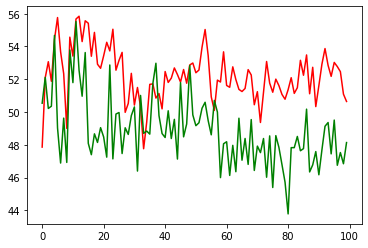

In [131]:
import matplotlib.pyplot as plt
x = np.array(range(len(results[1]['mml-pgg-off-sim']['f'])))

mml_mml_off_r_avg = results[1]['mml-mml-off-sim']['r'] + results[3]['mml-mml-off-sim']['r'] + results[4]['mml-mml-off-sim']['r']
mml_mml_on_r_avg = results[1]['mml-mml-on-sim']['r'] + results[3]['mml-mml-on-sim']['r'] + results[4]['mml-mml-on-sim']['r']
mml_pgg_off_r_avg = results[1]['mml-pgg-off-sim']['r'] + results[3]['mml-pgg-off-sim']['r'] + results[4]['mml-pgg-off-sim']['r']
mml_pgg_on_r_avg = results[1]['mml-pgg-on-sim']['r'] + results[3]['mml-pgg-on-sim']['r'] + results[4]['mml-pgg-on-sim']['r']

mml_mml_off_p_avg = results[1]['mml-mml-off-sim']['p'] + results[3]['mml-mml-off-sim']['p'] + results[4]['mml-mml-off-sim']['p']
mml_mml_on_p_avg = results[1]['mml-mml-on-sim']['p'] + results[3]['mml-mml-on-sim']['p'] + results[4]['mml-mml-on-sim']['p']
mml_pgg_off_p_avg = results[1]['mml-pgg-off-sim']['p'] + results[3]['mml-pgg-off-sim']['p'] + results[4]['mml-pgg-off-sim']['p']
mml_pgg_on_p_avg = results[1]['mml-pgg-on-sim']['p'] + results[3]['mml-pgg-on-sim']['p'] + results[4]['mml-pgg-on-sim']['p']

mml_mml_off_f_avg = results[1]['mml-mml-off-sim']['f'] + results[3]['mml-mml-off-sim']['f'] + results[4]['mml-mml-off-sim']['f']
mml_mml_on_f_avg = results[1]['mml-mml-on-sim']['f'] + results[3]['mml-mml-on-sim']['f'] + results[4]['mml-mml-on-sim']['f']
mml_pgg_off_f_avg = results[1]['mml-pgg-off-sim']['f'] + results[3]['mml-pgg-off-sim']['f'] + results[4]['mml-pgg-off-sim']['f']
mml_pgg_on_f_avg = results[1]['mml-pgg-on-sim']['f'] + results[3]['mml-pgg-on-sim']['f'] + results[4]['mml-pgg-on-sim']['f']

plt.plot(x, mml_pgg_off_f_avg/3.0, 'r')
plt.plot(x, mml_mml_off_f_avg/3.0, 'g')
#plt.plot(x, mml_mml_on_f_avg/3.0, 'y')
#plt.plot(x, mml_pgg_on_f_avg/3.0, 'b')
plt.show()

In [41]:
# Evaluating the dev predictions on the RE-QA dataset using the model having access to gold templates!
for fold_i in range(1, 11, 1):
    fold_gold_file = "./zero-shot-extraction/relation_splits/dev.{}".format(fold_i-1)
    fold_path = "/home/saeednjf/scratch/feb-15-2022-arr/fold_{}/gold/dev_predictions/".format(fold_i)
    fold_files = ["gold_fold.{}.dev.predictions.step.{}.csv".format(fold_i, 100 * i) for i in range(1, 506, 1)]
    preprocess_the_prediction_files(fold_path, fold_files)
    max_file,  max_f1, f1s, scores = unk_eval_the_prediction_files(fold_files, fold_gold_file)
    print(fold_i, max_file, max_f1)
    print("#")

1 gold_fold.1.dev.predictions.step.800.csv 56.83
#
2 gold_fold.2.dev.predictions.step.2000.csv 65.76
#
3 gold_fold.3.dev.predictions.step.4200.csv 63.59
#
4 gold_fold.4.dev.predictions.step.1400.csv 64.44
#
5 gold_fold.5.dev.predictions.step.900.csv 67.0
#
6 gold_fold.6.dev.predictions.step.400.csv 69.45
#
7 gold_fold.7.dev.predictions.step.6100.csv 59.3
#
8 gold_fold.8.dev.predictions.step.7300.csv 64.1
#
9 gold_fold.9.dev.predictions.step.1800.csv 67.48
#
10 gold_fold.10.dev.predictions.step.4100.csv 61.41
#


In [42]:
# Evaluating the dev predictions on the RE-QA dataset using the model having access to psuedo questions.
for fold_i in range(1, 11, 1):
    fold_gold_file = "./zero-shot-extraction/relation_splits/dev.{}".format(fold_i-1)
    fold_path = "/home/saeednjf/scratch/feb-15-2022-arr/fold_{}/concat/dev_predictions/".format(fold_i)
    fold_files = ["concat_fold.{}.dev.predictions.step.{}.csv".format(fold_i, 100 * i) for i in range(1, 506, 1)]
    preprocess_the_prediction_files(fold_path, fold_files)
    max_file,  max_f1, f1s, scores = unk_eval_the_prediction_files(fold_files, fold_gold_file)
    print(fold_i, max_file, max_f1)
    print("#")

1 concat_fold.1.dev.predictions.step.1700.csv 53.96
#
2 concat_fold.2.dev.predictions.step.4600.csv 64.46
#
3 concat_fold.3.dev.predictions.step.18600.csv 61.4
#
4 concat_fold.4.dev.predictions.step.1400.csv 67.12
#
5 concat_fold.5.dev.predictions.step.7900.csv 69.91
#
6 concat_fold.6.dev.predictions.step.2600.csv 64.16
#
7 concat_fold.7.dev.predictions.step.24700.csv 63.0
#
8 concat_fold.8.dev.predictions.step.13800.csv 61.08
#
9 concat_fold.9.dev.predictions.step.17700.csv 61.6
#
10 concat_fold.10.dev.predictions.step.35500.csv 57.72
#


In [4]:
def compute_macro_PRF(predicted_idx, gold_idx, i=-1, empty_label=None):
    '''
    This evaluation function follows work from Sorokin and Gurevych(https://www.aclweb.org/anthology/D17-1188.pdf)
    code borrowed from the following link:
    https://github.com/UKPLab/emnlp2017-relation-extraction/blob/master/relation_extraction/evaluation/metrics.py
    '''
    if i == -1:
        i = len(predicted_idx)

    complete_rel_set = set(gold_idx) - {empty_label}
    avg_prec = 0.0
    avg_rec = 0.0

    for r in complete_rel_set:
        r_indices = (predicted_idx[:i] == r)
        tp = len((predicted_idx[:i][r_indices] == gold_idx[:i][r_indices]).nonzero()[0])
        tp_fp = len(r_indices.nonzero()[0])
        tp_fn = len((gold_idx == r).nonzero()[0])
        prec = (tp / tp_fp) if tp_fp > 0 else 0
        rec = tp / tp_fn
        avg_prec += prec
        avg_rec += rec
    f1 = 0
    avg_prec = avg_prec / len(set(predicted_idx[:i]))
    avg_rec = avg_rec / len(complete_rel_set)
    if (avg_rec+avg_prec) > 0:
        f1 = 2.0 * avg_prec * avg_rec / (avg_prec + avg_rec)

    return avg_prec, avg_rec, f1

In [8]:
import pandas as pd
import numpy as np

id_file = "~/QA-ZRE/rel_fewrl_data/val_ids_12321.csv"
gold_file = "~/QA-ZRE/rel_fewrl_data/val_data_12321.csv"

prediction_files = ["~/fewrl/concat_run_1/relation.concat.run.0.dev.predictions.step.{}.csv".format(100 * i) for i in range(1, 27, 1)]
prediction_files += ["~/fewrl/concat_run_1/relation.concat.run.1.dev.predictions.step.{}.csv".format(100 * i) for i in range(1, 27, 1)]
prediction_files += ["~/fewrl/concat_run_1/relation.concat.run.2.dev.predictions.step.{}.csv".format(100 * i) for i in range(1, 27, 1)]
prediction_files += ["~/fewrl/concat_run_1/relation.concat.run.3.dev.predictions.step.{}.csv".format(100 * i) for i in range(1, 27, 1)]

df = pd.read_csv(gold_file, sep=',')
ids = {i:val for i, val in enumerate(pd.read_csv(id_file, sep=',')["relation_ids"].tolist())}
actual_ids = df["actual_ids"].tolist()
num_examples = len(actual_ids) // 5
actual_ids = np.argmax(np.reshape(np.array(actual_ids), (num_examples, 5)), axis=1)

max_f1 = 0.0
max_file = "None"
for prediction_file in prediction_files:
    pred_log_ps = pd.read_csv(prediction_file, sep=',')["relation_log_p"].tolist()
    pred_ids = np.argmax(np.reshape(np.array(pred_log_ps), (num_examples, 5)), axis=1)
    avg_prec, avg_rec, f1 = compute_macro_PRF(pred_ids, actual_ids)
    if max_f1 <= f1:
        max_f1 = f1
        max_file = prediction_file

print(max_file, max_f1)

~/fewrl/concat_run_1/relation.concat.run.1.dev.predictions.step.900.csv 0.2350029463759576


In [9]:
import pandas as pd
import numpy as np

id_file = "~/QA-ZRE/unk_fewrl_data/val_ids_12321.csv"
gold_file = "~/QA-ZRE/unk_fewrl_data/val_data_12321.csv"
prediction_file = "~/fewrl/run_1/relation.unk.mml-pgg-off-sim.run.0.dev.predictions.step.5200.csv"
df = pd.read_csv(gold_file, sep=',')

ids = {i:val for i, val in enumerate(pd.read_csv(id_file, sep=',')["relation_ids"].tolist())}

actual_ids = df["actual_ids"].tolist()

print(actual_ids[0:100])

num_examples = len(actual_ids) // 5

actual_ids = np.argmax(np.reshape(np.array(actual_ids), (num_examples, 5)), axis=1)

pred_log_ps = pd.read_csv(prediction_file, sep=',')["relation_log_p"].tolist()
print(pred_log_ps[:20])
pred_ids = np.argmax(np.reshape(np.array(pred_log_ps), (num_examples, 5)), axis=1)
print(pred_ids[0:100])
avg_prec, avg_rec, f1 = compute_macro_PRF(pred_ids, actual_ids)
print(f1)

['P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408']
[-0.6911495, -12.227538000000001, -4.965505, -15.330715, -8.0793495, -15.859772, -25.396414, -17.50

In [8]:
import pandas as pd
import numpy as np

id_file = "~/QA-ZRE/unk_fewrl_data/val_ids_12321.csv"
gold_file = "~/QA-ZRE/unk_fewrl_data/val_data_12321.csv"
prediction_file = "~/fewrl/run_1/relation.unk.mml-mml-off-sim.run.0.dev.predictions.step.5200.csv"
df = pd.read_csv(gold_file, sep=',')

ids = {i:val for i, val in enumerate(pd.read_csv(id_file, sep=',')["relation_ids"].tolist())}

actual_ids = df["actual_ids"].tolist()

print(actual_ids[0:100])

num_examples = len(actual_ids) // 5

actual_ids = np.argmax(np.reshape(np.array(actual_ids), (num_examples, 5)), axis=1)

pred_log_ps = pd.read_csv(prediction_file, sep=',')["relation_log_p"].tolist()
print(pred_log_ps[:20])
pred_ids = np.argmax(np.reshape(np.array(pred_log_ps), (num_examples, 5)), axis=1)
print(pred_ids[0:100])
avg_prec, avg_rec, f1 = compute_macro_PRF(pred_ids, actual_ids)
print(f1)

['P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408', 'P1408']
[-0.7031368, -19.062004, -1.5099378, -17.406715, -13.607196, -16.561901000000002, -22.0894899999999

In [6]:
import pandas as pd
import numpy as np

gold_file = "~/Desktop/codes/repos/QA-ZRE/nce_fewrel_data/data.csv"
prediction_file = "~/Desktop/codes/repos/fewrl/run_1/fold_1_gold_entity_relation.gold_fold.1.dev.predictions.step.52500.csv"
df = pd.read_csv(gold_file, sep=',')
answers = df["answers"].tolist()
answers = [ans.replace(" </s>", "") for ans in answers]

pred_df = pd.read_csv(prediction_file, sep=',')
predictions = pred_df["predictions_str"].tolist()

tpc = 0.0
num_non_null_entity = 0.0
num_gen_non_null_entity = 0.0
for i in range(len(answers)):
    if answers[i] == predictions[i] and answers[i] != "no_answer":
        tpc += 1
    if answers[i] != "no_answer":
        num_non_null_entity += 1
    if predictions[i] != "no_answer":
        num_gen_non_null_entity += 1

print(num_non_null_entity)
print(num_gen_non_null_entity)
print("recall:", tpc / num_non_null_entity)
print("precision:", tpc / num_gen_non_null_entity)

'''
ids = {i:val for i, val in enumerate(pd.read_csv(id_file, sep=',')["relation_ids"].tolist())}

print(actual_ids[0:100])

num_examples = len(actual_ids) // 5

actual_ids = np.argmax(np.reshape(np.array(actual_ids), (num_examples, 5)), axis=1)

pred_log_ps = pd.read_csv(prediction_file, sep=',')["relation_log_p"].tolist()
print(pred_log_ps[:20])
pred_ids = np.argmax(np.reshape(np.array(pred_log_ps), (num_examples, 5)), axis=1)
print(pred_ids[0:100])
avg_prec, avg_rec, f1 = compute_macro_PRF(pred_ids, actual_ids)
print(f1)
'''

300.0
717.0
recall: 0.2866666666666667
precision: 0.1199442119944212


'\nids = {i:val for i, val in enumerate(pd.read_csv(id_file, sep=\',\')["relation_ids"].tolist())}\n\nprint(actual_ids[0:100])\n\nnum_examples = len(actual_ids) // 5\n\nactual_ids = np.argmax(np.reshape(np.array(actual_ids), (num_examples, 5)), axis=1)\n\npred_log_ps = pd.read_csv(prediction_file, sep=\',\')["relation_log_p"].tolist()\nprint(pred_log_ps[:20])\npred_ids = np.argmax(np.reshape(np.array(pred_log_ps), (num_examples, 5)), axis=1)\nprint(pred_ids[0:100])\navg_prec, avg_rec, f1 = compute_macro_PRF(pred_ids, actual_ids)\nprint(f1)\n'

In [25]:
# Eval of the RE-QA using the Gold Templates on the dev data over the fold 1.
import pandas as pd
import numpy as np

for fold_i in range(1, 3, 1):
    gold_file = "~/QA-ZRE/zero-shot-extraction/relation_splits/dev.{}.relation_data.csv".format(str(fold_i-1))
    gold_indices = []
    df = pd.read_csv(gold_file, sep=',')
    correct_indices = df["correct_indices"].tolist()
    for i, index in enumerate(correct_indices):
        if index:
            gold_indices.append(int(i % 12))

    num_examples = len(correct_indices) // 12
    gold_indices = np.array(gold_indices)

    max_file = None
    max_f1 = 0.0
    for checkpoint_i in range(1, 506, 1):
        prediction_file = "~/fold_{}/gold/relation.gold.dev.predictions.fold.{}.step.{}.csv".format(str(fold_i), str(fold_i), str(100 * checkpoint_i))
        pred_log_ps = pd.read_csv(prediction_file, sep=',')["relation_log_p"].tolist()
        pred_ids = np.argmax(np.reshape(np.array(pred_log_ps), (num_examples, 12)), axis=1)
        avg_prec, avg_rec, f1 = compute_macro_PRF(pred_ids, gold_indices)
        if f1 >= max_f1:
            max_f1 = f1
            max_file = prediction_file

    print(fold_i)
    print(max_f1)
    print(max_file)
    print("\r\n")

1
0.8097916859604715
~/fold_1/gold/relation.gold.dev.predictions.fold.1.step.2500.csv


2
0.8331326492522585
~/fold_2/gold/relation.gold.dev.predictions.fold.2.step.6600.csv




In [ ]:
'''
1
0.8097916859604715
~/fold_1/gold/relation.gold.dev.predictions.fold.1.step.2500.csv


2
0.8331326492522585
~/fold_2/gold/relation.gold.dev.predictions.fold.2.step.6600.csv
'''

In [9]:
# Eval of the RE-QA using the Gold Templates on the dev data over the fold 1.
import pandas as pd
import numpy as np

fold_checkpoint = {
    1: 2500,
    2: 6600
}
for fold_i in range(1, 3, 1):
    gold_file = "~/QA-ZRE/zero-shot-extraction/relation_splits/test.{}.relation_data.csv".format(str(fold_i-1))
    gold_indices = []
    df = pd.read_csv(gold_file, sep=',')
    correct_indices = df["correct_indices"].tolist()
    for i, index in enumerate(correct_indices):
        if index:
            gold_indices.append(int(i % 24))

    num_examples = len(correct_indices) // 24
    gold_indices = np.array(gold_indices)

    prediction_file = "~/fold_{}/gold/relation.gold.test.predictions.fold.{}.step.{}.csv".format(str(fold_i), str(fold_i), str(fold_checkpoint[fold_i]))
    pred_log_ps = pd.read_csv(prediction_file, sep=',')["relation_log_p"].tolist()
    pred_ids = np.argmax(np.reshape(np.array(pred_log_ps), (num_examples, 24)), axis=1)

    avg_prec, avg_rec, f1 = compute_macro_PRF(pred_ids, gold_indices)
    print(fold_i)
    print(avg_prec, avg_rec, f1)
    print(prediction_file)
    print("\r\n")

1
0.7016410071156501 0.7013333333333333 0.701487136487896
~/fold_1/gold/relation.gold.test.predictions.fold.1.step.2500.csv


2
0.6102377060671086 0.5776666666666667 0.5935056552184317
~/fold_2/gold/relation.gold.test.predictions.fold.2.step.6600.csv




In [19]:
# Eval of the RE-QA using the Concat Templates on the dev data over the fold 1.
import pandas as pd
import numpy as np

for fold_i in range(1, 2, 1):
    gold_file = "~/QA-ZRE/zero-shot-extraction/relation_splits/dev.{}.concat.relation_data.csv".format(str(fold_i-1))
    gold_indices = []
    df = pd.read_csv(gold_file, sep=',')
    correct_indices = df["correct_indices"].tolist()
    for i, index in enumerate(correct_indices):
        if index:
            gold_indices.append(int(i % 12))

    num_examples = len(correct_indices) // 12
    gold_indices = np.array(gold_indices)

    max_file = None
    max_f1 = 0.0
    for checkpoint_i in range(1, 188, 1):
        prediction_file = "~/fold_{}/concat/relation.concat.dev.predictions.fold.{}.step.{}.csv".format(str(fold_i), str(fold_i), str(100 * checkpoint_i))
        pred_log_ps = pd.read_csv(prediction_file, sep=',')["relation_log_p"].tolist()
        pred_ids = np.argmax(np.reshape(np.array(pred_log_ps), (num_examples, 12)), axis=1)
        avg_prec, avg_rec, f1 = compute_macro_PRF(pred_ids, gold_indices)
        if f1 >= max_f1:
            max_f1 = f1
            max_file = prediction_file

    print(fold_i)
    print(max_f1)
    print(max_file)
    print("\r\n")

1
0.6645079529607614
~/fold_1/concat/relation.concat.dev.predictions.fold.1.step.3600.csv




In [11]:
# Eval of the RE-QA using the MML-PGG-oFF-Sim Templates on the dev data over the fold 1.
import pandas as pd
import numpy as np

for fold_i in range(1, 2, 1):
    gold_file = "~/QA-ZRE/zero-shot-extraction/relation_splits/dev.{}.qq.relation_data.csv".format(str(fold_i-1))
    gold_indices = []
    df = pd.read_csv(gold_file, sep=',')
    correct_indices = df["correct_indices"].tolist()
    for i, index in enumerate(correct_indices):
        if index:
            gold_indices.append(int(i % 12))

    num_examples = len(correct_indices) // 12
    gold_indices = np.array(gold_indices)

    max_file = None
    max_f1 = 0.0
    for checkpoint_i in range(93, 94, 1):
        prediction_file = "~/fold_{}/mml-pgg-off-sim/relation.mml-pgg-off-sim.run.0.dev.predictions.step.{}.csv".format(str(fold_i), str(100 * checkpoint_i))
        pred_log_ps = pd.read_csv(prediction_file, sep=',')["relation_log_p"].tolist()
        pred_ids = np.argmax(np.reshape(np.array(pred_log_ps), (num_examples, 12)), axis=1)
        avg_prec, avg_rec, f1 = compute_macro_PRF(pred_ids, gold_indices)
        if f1 >= max_f1:
            max_f1 = f1
            max_file = prediction_file

    print(fold_i)
    print(max_f1)
    print(max_file)
    print("\r\n")

1
0.6447182716311557
~/fold_1/mml-pgg-off-sim/relation.mml-pgg-off-sim.run.0.dev.predictions.step.9300.csv




In [6]:
# Eval of the RE-QA using the Gold Templates on the dev data over the fold 1.
import pandas as pd
import numpy as np

fold_checkpoint = {
    1: 2500,
}
for fold_i in range(1, 2, 1):
    gold_file = "~/QA-ZRE/zero-shot-extraction/relation_splits/test.{}.relation_data.csv".format(str(fold_i-1))
    gold_indices = []
    df = pd.read_csv(gold_file, sep=',')
    correct_indices = df["correct_indices"].tolist()
    for i, index in enumerate(correct_indices):
        if index:
            gold_indices.append(int(i % 24))

    num_examples = len(correct_indices) // 24
    gold_indices = np.array(gold_indices)

    prediction_file = "~/fold_{}/gold/relation.gold.test.predictions.fold.{}.step.{}.csv".format(str(fold_i), str(fold_i), str(fold_checkpoint[fold_i]))
    pred_log_ps = pd.read_csv(prediction_file, sep=',')["relation_log_p"].tolist()
    pred_ids = np.argmax(np.reshape(np.array(pred_log_ps), (num_examples, 24)), axis=1)

    avg_prec, avg_rec, f1 = compute_macro_PRF(pred_ids, gold_indices)
    print(fold_i)
    print(avg_prec, avg_rec, f1)
    print(prediction_file)
    print("\r\n")

1
0.7016410071156501 0.7013333333333333 0.701487136487896
~/fold_1/gold/relation.gold.test.predictions.fold.1.step.2500.csv




In [7]:
# Eval of the RE-QA using the Concat Templates on the dev data over the fold 1.
import pandas as pd
import numpy as np

fold_checkpoint = {
    1: 3600,
}
for fold_i in range(1, 2, 1):
    gold_file = "~/QA-ZRE/zero-shot-extraction/relation_splits/test.{}.concat.relation_data.csv".format(str(fold_i-1))
    gold_indices = []
    df = pd.read_csv(gold_file, sep=',')
    correct_indices = df["correct_indices"].tolist()
    for i, index in enumerate(correct_indices):
        if index:
            gold_indices.append(int(i % 24))

    num_examples = len(correct_indices) // 24
    gold_indices = np.array(gold_indices)

    prediction_file = "~/fold_{}/concat/relation.concat.test.predictions.fold.{}.step.{}.csv".format(str(fold_i), str(fold_i), str(fold_checkpoint[fold_i]))
    pred_log_ps = pd.read_csv(prediction_file, sep=',')["relation_log_p"].tolist()
    pred_ids = np.argmax(np.reshape(np.array(pred_log_ps), (num_examples, 24)), axis=1)

    avg_prec, avg_rec, f1 = compute_macro_PRF(pred_ids, gold_indices)
    print(fold_i)
    print(avg_prec, avg_rec, f1)
    print(prediction_file)
    print("\r\n")

1
0.689066127748157 0.6813333333333333 0.6851779135044868
~/fold_1/concat/relation.concat.test.predictions.fold.1.step.3600.csv




In [9]:
# Eval of the RE-QA using the Concat Templates on the dev data over the fold 1.
import pandas as pd
import numpy as np

fold_checkpoint = {
    1: 9300,
}
for fold_i in range(1, 2, 1):
    gold_file = "~/QA-ZRE/zero-shot-extraction/relation_splits/test.{}.qq.relation_data.csv".format(str(fold_i-1))
    gold_indices = []
    df = pd.read_csv(gold_file, sep=',')
    correct_indices = df["correct_indices"].tolist()
    for i, index in enumerate(correct_indices):
        if index:
            gold_indices.append(int(i % 24))

    num_examples = len(correct_indices) // 24
    gold_indices = np.array(gold_indices)

    prediction_file = "~/fold_{}/mml-pgg-off-sim/relation.mml-pgg-off-sim.run.0.test.predictions.step.{}.csv".format(str(fold_i), str(fold_checkpoint[fold_i]))
    pred_log_ps = pd.read_csv(prediction_file, sep=',')["relation_log_p"].tolist()
    pred_ids = np.argmax(np.reshape(np.array(pred_log_ps), (num_examples, 24)), axis=1)

    avg_prec, avg_rec, f1 = compute_macro_PRF(pred_ids, gold_indices)
    print(fold_i)
    print(avg_prec, avg_rec, f1)
    print(prediction_file)
    print("\r\n")

1
0.609839655658675 0.5775 0.5932294090649438
~/fold_1/mml-pgg-off-sim/relation.mml-pgg-off-sim.run.0.test.predictions.step.9300.csv


